# JetBot Steering + Speed - PC Training Notebook

This notebook runs on your **PC** for training the steering + speed model.

## Cells
1. **Config** - All parameters
2. **Dataset** - Load and analyze data
3. **Model** - Define ResNet18 with 2 outputs
4. **Training** - Train with early stopping
5. **Evaluation** - Visualize results with telemetry

In [1]:
# =============================================================================
# CELL 1: CONFIGURATION
# =============================================================================

import torch
import os

# -----------------------------------------------------------------------------
# PATHS
# -----------------------------------------------------------------------------
DATASET_DIR = 'dataset_steering_speed_v1'
DAGGER_DIR = 'dataset_steering_speed_dagger'
MODEL_SAVE_PATH = 'steering_speed_model_v1.pth'

# -----------------------------------------------------------------------------
# PREPROCESSING (must match JetBot notebook)
# -----------------------------------------------------------------------------
CROP_TOP = 0.20
CROP_BOTTOM = 0.00
CROP_LEFT = 0.08
CROP_RIGHT = 0.12
INPUT_SIZE = (224, 224)

# ImageNet normalization
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

# -----------------------------------------------------------------------------
# SPEED (for reference)
# -----------------------------------------------------------------------------
MIN_SPEED = 0.12
MAX_SPEED = 0.25

# -----------------------------------------------------------------------------
# TRAINING
# -----------------------------------------------------------------------------
BATCH_SIZE = 8
LEARNING_RATE = 1e-4
EPOCHS = 50
PATIENCE = 7
VAL_SPLIT = 0.2

# Loss weights
STEERING_LOSS_WEIGHT = 1.0
SPEED_LOSS_WEIGHT = 1.0

# -----------------------------------------------------------------------------
# AUGMENTATION
# -----------------------------------------------------------------------------
AUG_BRIGHTNESS = 0.3
AUG_CONTRAST = 0.3
AUG_SATURATION = 0.3
AUG_HUE = 0.05

# -----------------------------------------------------------------------------
# DEVICE
# -----------------------------------------------------------------------------
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Configuration loaded.")
print(f"  Device: {DEVICE}")
print(f"  Dataset: {DATASET_DIR}")
print(f"  Model: {MODEL_SAVE_PATH}")

Configuration loaded.
  Device: cuda
  Dataset: dataset_steering_speed_v1
  Model: steering_speed_model_v1.pth


In [2]:
# =============================================================================
# CELL 2: DATASET
# =============================================================================

import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchvision import transforms

# -----------------------------------------------------------------------------
# Dataset Class
# -----------------------------------------------------------------------------
class SteeringSpeedDataset(Dataset):
    """
    Dataset for steering + speed.
    Filename format: {timestamp}_{steering}_{speed_factor}.jpg
    """
    
    def __init__(self, file_list, transform=None):
        self.files = file_list
        self.transform = transform
    
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        filepath = self.files[idx]
        
        # Load image
        img_bgr = cv2.imread(filepath)
        if img_bgr is None:
            return torch.zeros(3, INPUT_SIZE[0], INPUT_SIZE[1]), torch.tensor([0.0, 0.0])
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        
        # Apply transforms
        if self.transform:
            img_tensor = self.transform(img_rgb)
        else:
            img_tensor = torch.from_numpy(img_rgb.transpose(2, 0, 1)).float() / 255.0
        
        # Extract steering and speed from filename
        # Format: {timestamp}_{steering}_{speed_factor}.jpg
        filename = os.path.basename(filepath)
        try:
            parts = filename.replace('.jpg', '').split('_')
            steering = float(parts[1])
            speed_factor = float(parts[2])
        except (IndexError, ValueError):
            steering, speed_factor = 0.0, 0.0
        
        # Return as [steering, speed_factor]
        labels = torch.tensor([steering, speed_factor], dtype=torch.float32)
        
        return img_tensor, labels


# -----------------------------------------------------------------------------
# Transforms
# -----------------------------------------------------------------------------
def get_training_transforms():
    return transforms.Compose([
        transforms.ToPILImage(),
        transforms.ColorJitter(
            brightness=AUG_BRIGHTNESS,
            contrast=AUG_CONTRAST,
            saturation=AUG_SATURATION,
            hue=AUG_HUE
        ),
        transforms.ToTensor(),
        transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
    ])


def get_validation_transforms():
    return transforms.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor(),
        transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
    ])


# -----------------------------------------------------------------------------
# Load Dataset
# -----------------------------------------------------------------------------
def load_dataset(dataset_dirs, val_split=VAL_SPLIT):
    """Load dataset from one or more directories."""
    if isinstance(dataset_dirs, str):
        dataset_dirs = [dataset_dirs]
    
    all_files = []
    for d in dataset_dirs:
        files = glob.glob(os.path.join(d, "*.jpg"))
        all_files.extend(files)
        print(f"  {d}: {len(files)} images")
    
    all_files = sorted(all_files)
    print(f"Total: {len(all_files)} images")
    
    if len(all_files) == 0:
        raise ValueError("No images found!")
    
    # Split
    train_files, val_files = train_test_split(
        all_files, test_size=val_split, shuffle=True, random_state=42
    )
    print(f"Train: {len(train_files)} | Val: {len(val_files)}")
    
    # Create datasets and loaders
    train_dataset = SteeringSpeedDataset(train_files, transform=get_training_transforms())
    val_dataset = SteeringSpeedDataset(val_files, transform=get_validation_transforms())
    
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                              num_workers=4, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False,
                            num_workers=4, pin_memory=True)
    
    return train_dataset, val_dataset, train_loader, val_loader


# -----------------------------------------------------------------------------
# Analysis Functions
# -----------------------------------------------------------------------------
def analyze_dataset(dataset_dirs):
    """Analyze steering and speed distribution."""
    if isinstance(dataset_dirs, str):
        dataset_dirs = [dataset_dirs]
    
    all_files = []
    for d in dataset_dirs:
        all_files.extend(glob.glob(os.path.join(d, "*.jpg")))
    
    steering_values = []
    speed_values = []
    
    for f in all_files:
        try:
            parts = os.path.basename(f).replace('.jpg', '').split('_')
            steering_values.append(float(parts[1]))
            speed_values.append(float(parts[2]))
        except:
            pass
    
    steering_values = np.array(steering_values)
    speed_values = np.array(speed_values)
    
    # Statistics
    print("="*50)
    print("DATASET ANALYSIS")
    print("="*50)
    print(f"Total images: {len(all_files)}")
    print(f"\nSteering:")
    print(f"  Range: [{steering_values.min():.3f}, {steering_values.max():.3f}]")
    print(f"  Mean: {steering_values.mean():.3f}, Std: {steering_values.std():.3f}")
    print(f"\nSpeed Factor:")
    print(f"  Range: [{speed_values.min():.3f}, {speed_values.max():.3f}]")
    print(f"  Mean: {speed_values.mean():.3f}, Std: {speed_values.std():.3f}")
    print("="*50)
    
    # Plot
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    
    # Steering histogram
    axes[0, 0].hist(steering_values, bins=50, edgecolor='black', alpha=0.7)
    axes[0, 0].axvline(x=0, color='r', linestyle='--')
    axes[0, 0].set_xlabel('Steering')
    axes[0, 0].set_ylabel('Count')
    axes[0, 0].set_title('Steering Distribution')
    
    # Speed histogram
    axes[0, 1].hist(speed_values, bins=50, edgecolor='black', alpha=0.7, color='orange')
    axes[0, 1].set_xlabel('Speed Factor')
    axes[0, 1].set_ylabel('Count')
    axes[0, 1].set_title('Speed Factor Distribution')
    
    # Steering over time
    axes[1, 0].plot(steering_values, alpha=0.7, linewidth=0.5)
    axes[1, 0].axhline(y=0, color='r', linestyle='--')
    axes[1, 0].set_xlabel('Frame')
    axes[1, 0].set_ylabel('Steering')
    axes[1, 0].set_title('Steering Over Time')
    
    # Speed over time
    axes[1, 1].plot(speed_values, alpha=0.7, linewidth=0.5, color='orange')
    axes[1, 1].set_xlabel('Frame')
    axes[1, 1].set_ylabel('Speed Factor')
    axes[1, 1].set_title('Speed Factor Over Time')
    
    plt.tight_layout()
    plt.show()
    
    # Steering vs Speed scatter
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.scatter(steering_values, speed_values, alpha=0.1, s=5)
    ax.set_xlabel('Steering')
    ax.set_ylabel('Speed Factor')
    ax.set_title('Steering vs Speed (expect: high speed when steering ~0)')
    ax.axvline(x=0, color='r', linestyle='--', alpha=0.5)
    plt.show()
    
    return steering_values, speed_values


def visualize_samples(dataset_dirs, num_samples=8):
    """Display random samples with steering and speed."""
    if isinstance(dataset_dirs, str):
        dataset_dirs = [dataset_dirs]
    
    all_files = []
    for d in dataset_dirs:
        all_files.extend(glob.glob(os.path.join(d, "*.jpg")))
    
    indices = np.random.choice(len(all_files), min(num_samples, len(all_files)), replace=False)
    
    cols = 4
    rows = (len(indices) + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(3*cols, 3.5*rows))
    axes = axes.flatten()
    
    for i, idx in enumerate(indices):
        filepath = all_files[idx]
        img = cv2.imread(filepath)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Parse filename
        parts = os.path.basename(filepath).replace('.jpg', '').split('_')
        steering = float(parts[1])
        speed = float(parts[2])
        
        axes[i].imshow(img_rgb)
        axes[i].set_title(f'Steer: {steering:.2f}\nSpeed: {speed:.2f}')
        axes[i].axis('off')
    
    for i in range(len(indices), len(axes)):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()


def visualize_augmentation(dataset_dir, num_samples=5):
    """Show original image and augmented versions."""
    all_files = glob.glob(os.path.join(dataset_dir, "*.jpg"))
    img_path = random.choice(all_files)
    
    img_bgr = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    
    transform = get_training_transforms()
    
    fig, axes = plt.subplots(1, num_samples + 1, figsize=(3 * (num_samples + 1), 3))
    
    # Original
    axes[0].imshow(img_rgb)
    axes[0].set_title('Original')
    axes[0].axis('off')
    
    # Augmented
    for i in range(num_samples):
        augmented = transform(img_rgb)
        
        # Denormalize for display
        denorm = augmented.clone()
        for c in range(3):
            denorm[c] = denorm[c] * IMAGENET_STD[c] + IMAGENET_MEAN[c]
        denorm = torch.clamp(denorm, 0, 1)
        
        display_img = denorm.permute(1, 2, 0).numpy()
        axes[i + 1].imshow(display_img)
        axes[i + 1].set_title(f'Augmented {i + 1}')
        axes[i + 1].axis('off')
    
    plt.tight_layout()
    plt.show()


print("Dataset functions loaded.")

Dataset functions loaded.


In [3]:
# =============================================================================
# CELL 3: MODEL
# =============================================================================

import torch.nn as nn
import torchvision.models as models

def get_model(pretrained=True):
    """
    Create ResNet18 model with 2 outputs: steering and speed_factor.
    """
    if pretrained:
        model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        print("Loaded ResNet18 with ImageNet pretrained weights")
    else:
        model = models.resnet18(weights=None)
        print("Loaded ResNet18 without pretrained weights")
    
    # Replace final layer: 1000 classes -> 2 outputs (steering, speed_factor)
    model.fc = nn.Linear(model.fc.in_features, 2)
    
    return model


def print_model_summary(model):
    """Print model info and test forward pass."""
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    print(f"Parameters: {total:,} total, {trainable:,} trainable")
    
    model.eval()
    dummy = torch.randn(1, 3, 224, 224)
    with torch.no_grad():
        out = model(dummy)
    print(f"Input: {dummy.shape} -> Output: {out.shape}")
    print(f"Output format: [steering, speed_factor]")


print("Model functions loaded.")

Model functions loaded.


In [4]:
# =============================================================================
# CELL 4: TRAINING
# =============================================================================

import torch.optim as optim
import time
from copy import deepcopy

def train_model(model, train_loader, val_loader, epochs=EPOCHS, lr=LEARNING_RATE,
                patience=PATIENCE, save_path=MODEL_SAVE_PATH):
    """Train model with combined steering + speed loss."""
    
    model = model.to(DEVICE)
    criterion = nn.MSELoss(reduction='none')  # Per-output loss
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
    
    history = {
        'train_loss': [], 'val_loss': [],
        'train_steering_loss': [], 'val_steering_loss': [],
        'train_speed_loss': [], 'val_speed_loss': [],
        'lr': []
    }
    
    best_val_loss = float('inf')
    best_model_state = None
    patience_counter = 0
    
    print("="*60)
    print(f"TRAINING | Device: {DEVICE} | Epochs: {epochs}")
    print(f"Loss weights: Steering={STEERING_LOSS_WEIGHT}, Speed={SPEED_LOSS_WEIGHT}")
    print("="*60)
    
    start_time = time.time()
    
    for epoch in range(epochs):
        # Train
        model.train()
        train_loss_sum = 0.0
        train_steering_sum = 0.0
        train_speed_sum = 0.0
        
        for images, labels in train_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            
            optimizer.zero_grad()
            outputs = model(images)  # [batch, 2]
            
            # Separate losses
            losses = criterion(outputs, labels)  # [batch, 2]
            steering_loss = losses[:, 0].mean()
            speed_loss = losses[:, 1].mean()
            
            # Weighted total
            total_loss = STEERING_LOSS_WEIGHT * steering_loss + SPEED_LOSS_WEIGHT * speed_loss
            
            total_loss.backward()
            optimizer.step()
            
            train_loss_sum += total_loss.item()
            train_steering_sum += steering_loss.item()
            train_speed_sum += speed_loss.item()
        
        # Validate
        model.eval()
        val_loss_sum = 0.0
        val_steering_sum = 0.0
        val_speed_sum = 0.0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                outputs = model(images)
                
                losses = criterion(outputs, labels)
                steering_loss = losses[:, 0].mean()
                speed_loss = losses[:, 1].mean()
                total_loss = STEERING_LOSS_WEIGHT * steering_loss + SPEED_LOSS_WEIGHT * speed_loss
                
                val_loss_sum += total_loss.item()
                val_steering_sum += steering_loss.item()
                val_speed_sum += speed_loss.item()
        
        # Averages
        n_train, n_val = len(train_loader), len(val_loader)
        avg_train = train_loss_sum / n_train
        avg_val = val_loss_sum / n_val
        avg_train_steer = train_steering_sum / n_train
        avg_val_steer = val_steering_sum / n_val
        avg_train_speed = train_speed_sum / n_train
        avg_val_speed = val_speed_sum / n_val
        current_lr = optimizer.param_groups[0]['lr']
        
        # Save history
        history['train_loss'].append(avg_train)
        history['val_loss'].append(avg_val)
        history['train_steering_loss'].append(avg_train_steer)
        history['val_steering_loss'].append(avg_val_steer)
        history['train_speed_loss'].append(avg_train_speed)
        history['val_speed_loss'].append(avg_val_speed)
        history['lr'].append(current_lr)
        
        # Check improvement
        improved = ""
        if avg_val < best_val_loss:
            best_val_loss = avg_val
            best_model_state = deepcopy(model.state_dict())
            torch.save(model.state_dict(), save_path)
            patience_counter = 0
            improved = "✓ BEST"
        else:
            patience_counter += 1
        
        print(f"Epoch {epoch+1:3d}/{epochs} | Train: {avg_train:.4f} | Val: {avg_val:.4f} | "
              f"Steer: {avg_val_steer:.4f} | Speed: {avg_val_speed:.4f} | LR: {current_lr:.2e} {improved}")
        
        scheduler.step(avg_val)
        
        if patience_counter >= patience:
            print(f"\nEarly stopping at epoch {epoch+1}")
            break
    
    print("="*60)
    print(f"Training complete in {(time.time()-start_time)/60:.1f} min")
    print(f"Best val loss: {best_val_loss:.6f}")
    print(f"Model saved to: {save_path}")
    print("="*60)
    
    model.load_state_dict(best_model_state)
    return model, history


def plot_history(history):
    """Plot training curves for steering and speed."""
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    
    epochs = range(1, len(history['train_loss']) + 1)
    
    # Total loss
    axes[0, 0].plot(epochs, history['train_loss'], 'b-', label='Train')
    axes[0, 0].plot(epochs, history['val_loss'], 'r-', label='Val')
    best_epoch = history['val_loss'].index(min(history['val_loss'])) + 1
    axes[0, 0].axvline(x=best_epoch, color='g', linestyle='--', label=f'Best: {best_epoch}')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].set_title('Total Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True)
    
    # Steering loss
    axes[0, 1].plot(epochs, history['train_steering_loss'], 'b-', label='Train')
    axes[0, 1].plot(epochs, history['val_steering_loss'], 'r-', label='Val')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].set_title('Steering Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True)
    
    # Speed loss
    axes[1, 0].plot(epochs, history['train_speed_loss'], 'b-', label='Train')
    axes[1, 0].plot(epochs, history['val_speed_loss'], 'r-', label='Val')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Loss')
    axes[1, 0].set_title('Speed Loss')
    axes[1, 0].legend()
    axes[1, 0].grid(True)
    
    # Learning rate
    axes[1, 1].plot(epochs, history['lr'], 'g-')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Learning Rate')
    axes[1, 1].set_title('Learning Rate Schedule')
    axes[1, 1].set_yscale('log')
    axes[1, 1].grid(True)
    
    plt.tight_layout()
    plt.show()


print("Training functions loaded.")

Training functions loaded.


In [5]:
# =============================================================================
# CELL 5: EVALUATION & TELEMETRY
# =============================================================================

def evaluate_model(model, val_loader):
    """Evaluate model and return predictions."""
    model.eval()
    model.to(DEVICE)
    
    all_preds_steering = []
    all_preds_speed = []
    all_labels_steering = []
    all_labels_speed = []
    
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(DEVICE)
            outputs = model(images)
            
            all_preds_steering.extend(outputs[:, 0].cpu().numpy())
            all_preds_speed.extend(outputs[:, 1].cpu().numpy())
            all_labels_steering.extend(labels[:, 0].numpy())
            all_labels_speed.extend(labels[:, 1].numpy())
    
    results = {
        'pred_steering': np.array(all_preds_steering),
        'pred_speed': np.array(all_preds_speed),
        'label_steering': np.array(all_labels_steering),
        'label_speed': np.array(all_labels_speed)
    }
    
    # Metrics
    steering_mse = np.mean((results['pred_steering'] - results['label_steering']) ** 2)
    speed_mse = np.mean((results['pred_speed'] - results['label_speed']) ** 2)
    steering_mae = np.mean(np.abs(results['pred_steering'] - results['label_steering']))
    speed_mae = np.mean(np.abs(results['pred_speed'] - results['label_speed']))
    
    print("="*40)
    print("EVALUATION")
    print("="*40)
    print(f"Steering - MSE: {steering_mse:.6f}, MAE: {steering_mae:.6f}")
    print(f"Speed    - MSE: {speed_mse:.6f}, MAE: {speed_mae:.6f}")
    print("="*40)
    
    return results


def plot_predictions(results):
    """Plot predicted vs actual for steering and speed."""
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # Steering scatter
    axes[0, 0].scatter(results['label_steering'], results['pred_steering'], alpha=0.3, s=5)
    axes[0, 0].plot([-1, 1], [-1, 1], 'r--', label='Perfect')
    axes[0, 0].set_xlabel('Actual')
    axes[0, 0].set_ylabel('Predicted')
    axes[0, 0].set_title('Steering: Predicted vs Actual')
    axes[0, 0].set_xlim(-1.1, 1.1)
    axes[0, 0].set_ylim(-1.1, 1.1)
    axes[0, 0].legend()
    axes[0, 0].grid(True)
    
    # Speed scatter
    axes[0, 1].scatter(results['label_speed'], results['pred_speed'], alpha=0.3, s=5, color='orange')
    axes[0, 1].plot([0, 1], [0, 1], 'r--', label='Perfect')
    axes[0, 1].set_xlabel('Actual')
    axes[0, 1].set_ylabel('Predicted')
    axes[0, 1].set_title('Speed Factor: Predicted vs Actual')
    axes[0, 1].set_xlim(-0.1, 1.1)
    axes[0, 1].set_ylim(-0.1, 1.1)
    axes[0, 1].legend()
    axes[0, 1].grid(True)
    
    # Steering error distribution
    steering_errors = results['pred_steering'] - results['label_steering']
    axes[1, 0].hist(steering_errors, bins=50, edgecolor='black', alpha=0.7)
    axes[1, 0].axvline(x=0, color='r', linestyle='--')
    axes[1, 0].set_xlabel('Error')
    axes[1, 0].set_ylabel('Count')
    axes[1, 0].set_title(f'Steering Error (mean={steering_errors.mean():.3f}, std={steering_errors.std():.3f})')
    
    # Speed error distribution
    speed_errors = results['pred_speed'] - results['label_speed']
    axes[1, 1].hist(speed_errors, bins=50, edgecolor='black', alpha=0.7, color='orange')
    axes[1, 1].axvline(x=0, color='r', linestyle='--')
    axes[1, 1].set_xlabel('Error')
    axes[1, 1].set_ylabel('Count')
    axes[1, 1].set_title(f'Speed Error (mean={speed_errors.mean():.3f}, std={speed_errors.std():.3f})')
    
    plt.tight_layout()
    plt.show()


def plot_telemetry(results, start=0, length=200):
    """
    Plot detailed telemetry: steering and speed predictions vs ground truth.
    """
    end = min(start + length, len(results['label_steering']))
    x = np.arange(start, end)
    
    fig, axes = plt.subplots(3, 1, figsize=(14, 9), sharex=True)
    
    # Steering
    axes[0].plot(x, results['label_steering'][start:end], 'b-', linewidth=1.5, label='Actual', alpha=0.8)
    axes[0].plot(x, results['pred_steering'][start:end], 'r--', linewidth=1.5, label='Predicted', alpha=0.8)
    axes[0].fill_between(x, results['label_steering'][start:end], results['pred_steering'][start:end], 
                         alpha=0.2, color='gray')
    axes[0].set_ylabel('Steering')
    axes[0].set_ylim(-1.1, 1.1)
    axes[0].legend(loc='upper right')
    axes[0].grid(True, alpha=0.3)
    axes[0].set_title(f'Telemetry: Frames {start} - {end}')
    
    # Speed
    axes[1].plot(x, results['label_speed'][start:end], 'b-', linewidth=1.5, label='Actual', alpha=0.8)
    axes[1].plot(x, results['pred_speed'][start:end], 'r--', linewidth=1.5, label='Predicted', alpha=0.8)
    axes[1].fill_between(x, results['label_speed'][start:end], results['pred_speed'][start:end],
                         alpha=0.2, color='gray')
    axes[1].set_ylabel('Speed Factor')
    axes[1].set_ylim(-0.1, 1.1)
    axes[1].legend(loc='upper right')
    axes[1].grid(True, alpha=0.3)
    
    # Errors
    steer_err = results['pred_steering'][start:end] - results['label_steering'][start:end]
    speed_err = results['pred_speed'][start:end] - results['label_speed'][start:end]
    axes[2].bar(x - 0.2, steer_err, width=0.4, color='blue', alpha=0.7, label='Steering Err')
    axes[2].bar(x + 0.2, speed_err, width=0.4, color='orange', alpha=0.7, label='Speed Err')
    axes[2].axhline(y=0, color='black', linewidth=0.5)
    axes[2].set_ylabel('Error')
    axes[2].set_xlabel('Frame')
    axes[2].set_ylim(-0.5, 0.5)
    axes[2].legend(loc='upper right')
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Stats
    print(f"Segment MAE - Steering: {np.mean(np.abs(steer_err)):.4f}, Speed: {np.mean(np.abs(speed_err)):.4f}")


def plot_saliency(model, image_path, output_idx=0):
    """
    Show saliency map for steering (output_idx=0) or speed (output_idx=1).
    """
    model.eval()
    model.to(DEVICE)
    
    img_bgr = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    
    transform = get_validation_transforms()
    img_tensor = transform(img_rgb).unsqueeze(0).to(DEVICE)
    img_tensor.requires_grad = True
    
    output = model(img_tensor)
    
    model.zero_grad()
    output[0, output_idx].backward()
    
    saliency = img_tensor.grad.data.abs().squeeze().cpu()
    saliency = saliency.max(dim=0)[0]
    saliency = (saliency - saliency.min()) / (saliency.max() - saliency.min() + 1e-8)
    
    output_name = 'Steering' if output_idx == 0 else 'Speed'
    pred_value = output[0, output_idx].item()
    
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    
    axes[0].imshow(img_rgb)
    axes[0].set_title('Original')
    axes[0].axis('off')
    
    axes[1].imshow(saliency.numpy(), cmap='hot')
    axes[1].set_title(f'Saliency ({output_name})')
    axes[1].axis('off')
    
    axes[2].imshow(img_rgb)
    axes[2].imshow(saliency.numpy(), cmap='hot', alpha=0.5)
    axes[2].set_title(f'Overlay (pred: {pred_value:.2f})')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()


print("Evaluation functions loaded.")

Evaluation functions loaded.


---
## Run Training

DATASET ANALYSIS
Total images: 11039

Steering:
  Range: [-1.000, 1.000]
  Mean: 0.199, Std: 0.577

Speed Factor:
  Range: [0.000, 1.000]
  Mean: 0.135, Std: 0.327


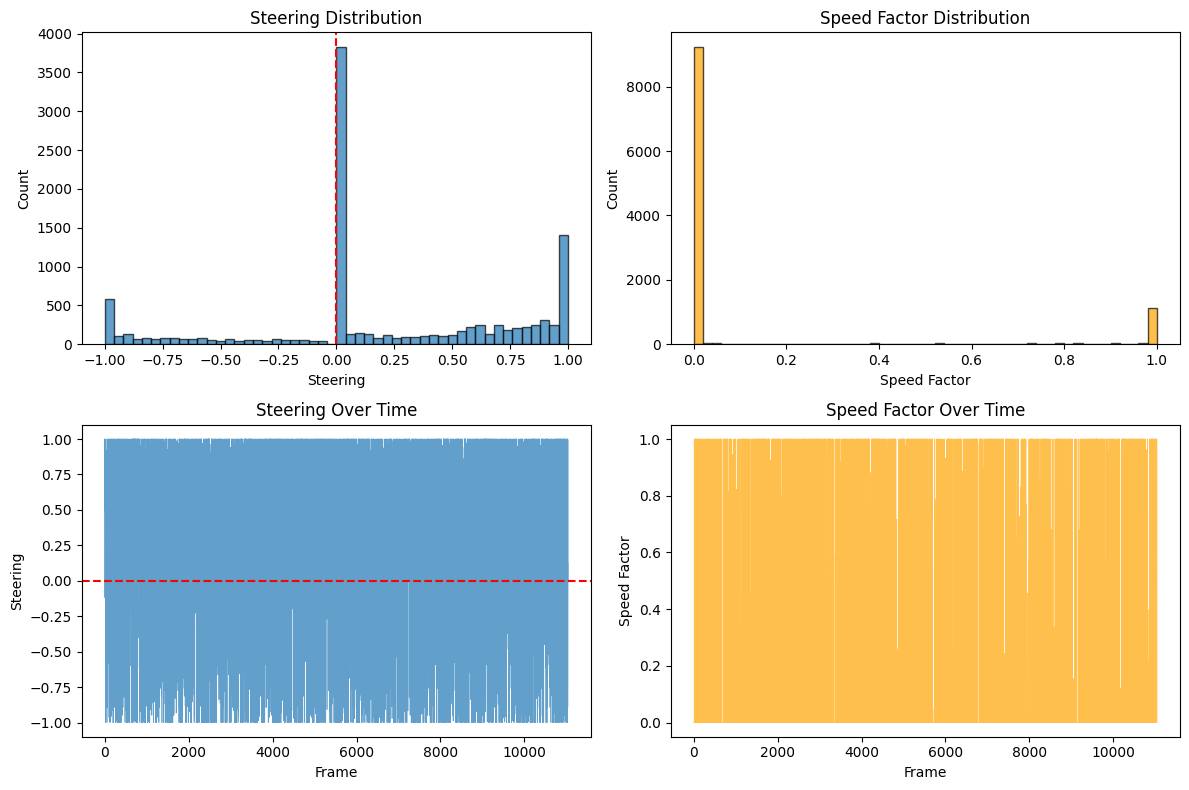

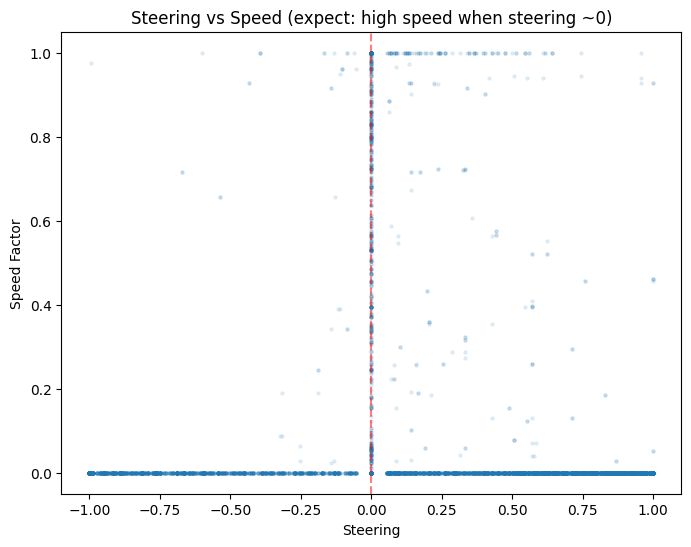

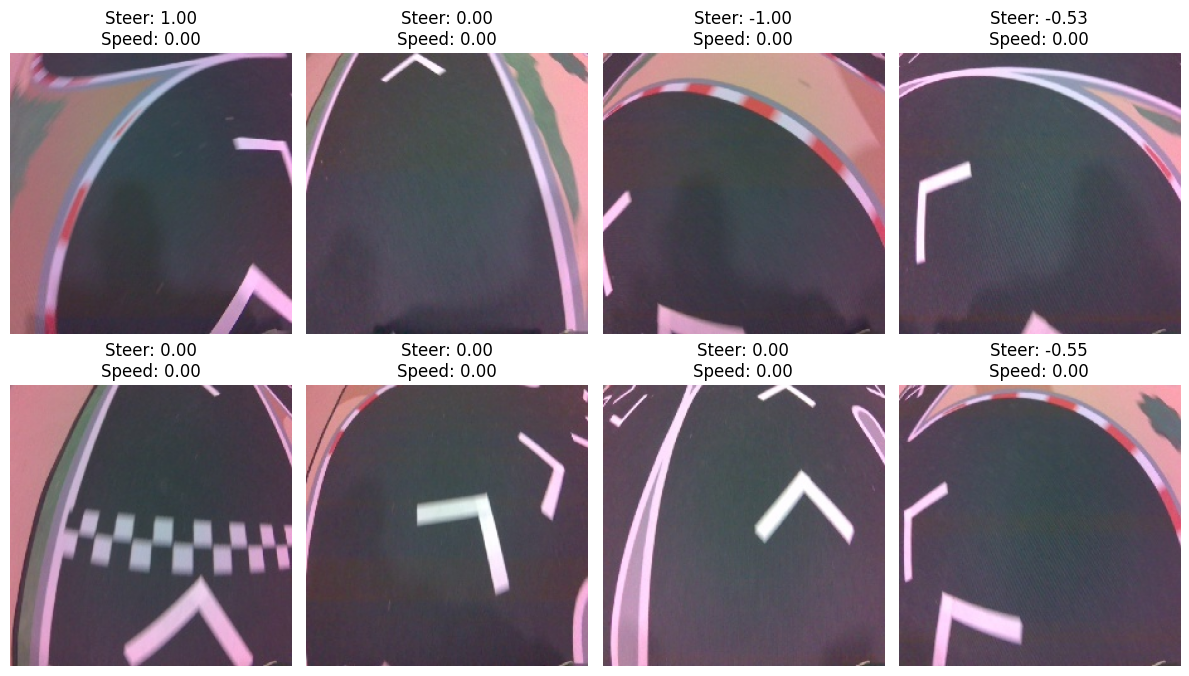

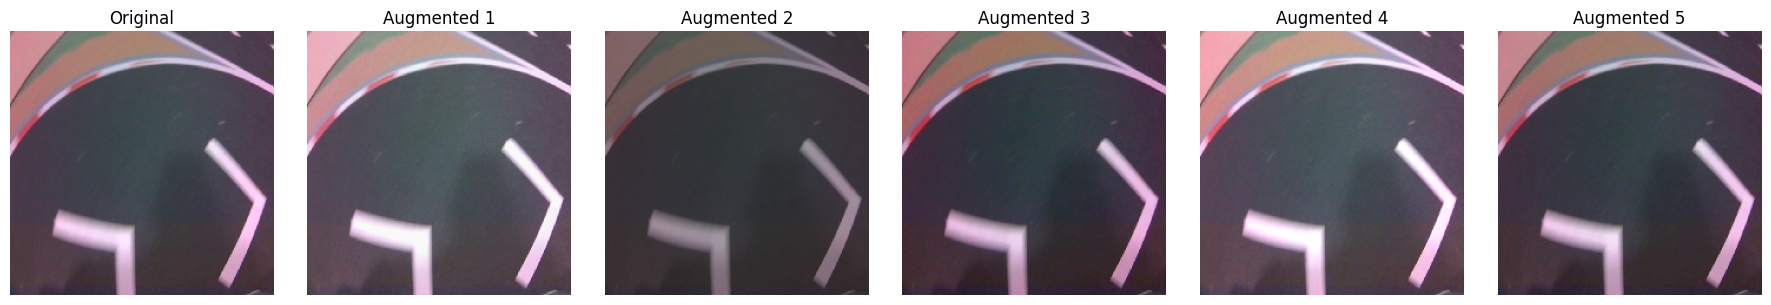

In [7]:
# Analyze dataset
steering_vals, speed_vals = analyze_dataset(DATASET_DIR)
visualize_samples(DATASET_DIR)
visualize_augmentation(DATASET_DIR)

In [8]:
# Load data
import gc
gc.collect()
torch.cuda.empty_cache()

train_dataset, val_dataset, train_loader, val_loader = load_dataset(DATASET_DIR)

  dataset_steering_speed_v1: 11039 images
Total: 11039 images
Train: 8831 | Val: 2208


In [9]:
# Create and train model
model = get_model(pretrained=True)
print_model_summary(model)
model, history = train_model(model, train_loader, val_loader)

Loaded ResNet18 with ImageNet pretrained weights
Parameters: 11,177,538 total, 11,177,538 trainable
Input: torch.Size([1, 3, 224, 224]) -> Output: torch.Size([1, 2])
Output format: [steering, speed_factor]
TRAINING | Device: cuda | Epochs: 50
Loss weights: Steering=1.0, Speed=1.0
Epoch   1/50 | Train: 0.1265 | Val: 0.0666 | Steer: 0.0488 | Speed: 0.0179 | LR: 1.00e-04 ✓ BEST
Epoch   2/50 | Train: 0.0653 | Val: 0.0664 | Steer: 0.0472 | Speed: 0.0192 | LR: 1.00e-04 ✓ BEST
Epoch   3/50 | Train: 0.0560 | Val: 0.0570 | Steer: 0.0441 | Speed: 0.0129 | LR: 1.00e-04 ✓ BEST
Epoch   4/50 | Train: 0.0496 | Val: 0.0652 | Steer: 0.0467 | Speed: 0.0185 | LR: 1.00e-04 
Epoch   5/50 | Train: 0.0444 | Val: 0.0525 | Steer: 0.0395 | Speed: 0.0129 | LR: 1.00e-04 ✓ BEST
Epoch   6/50 | Train: 0.0374 | Val: 0.0574 | Steer: 0.0433 | Speed: 0.0141 | LR: 1.00e-04 
Epoch   7/50 | Train: 0.0319 | Val: 0.0515 | Steer: 0.0408 | Speed: 0.0107 | LR: 1.00e-04 ✓ BEST
Epoch   8/50 | Train: 0.0257 | Val: 0.0545 | Steer: 

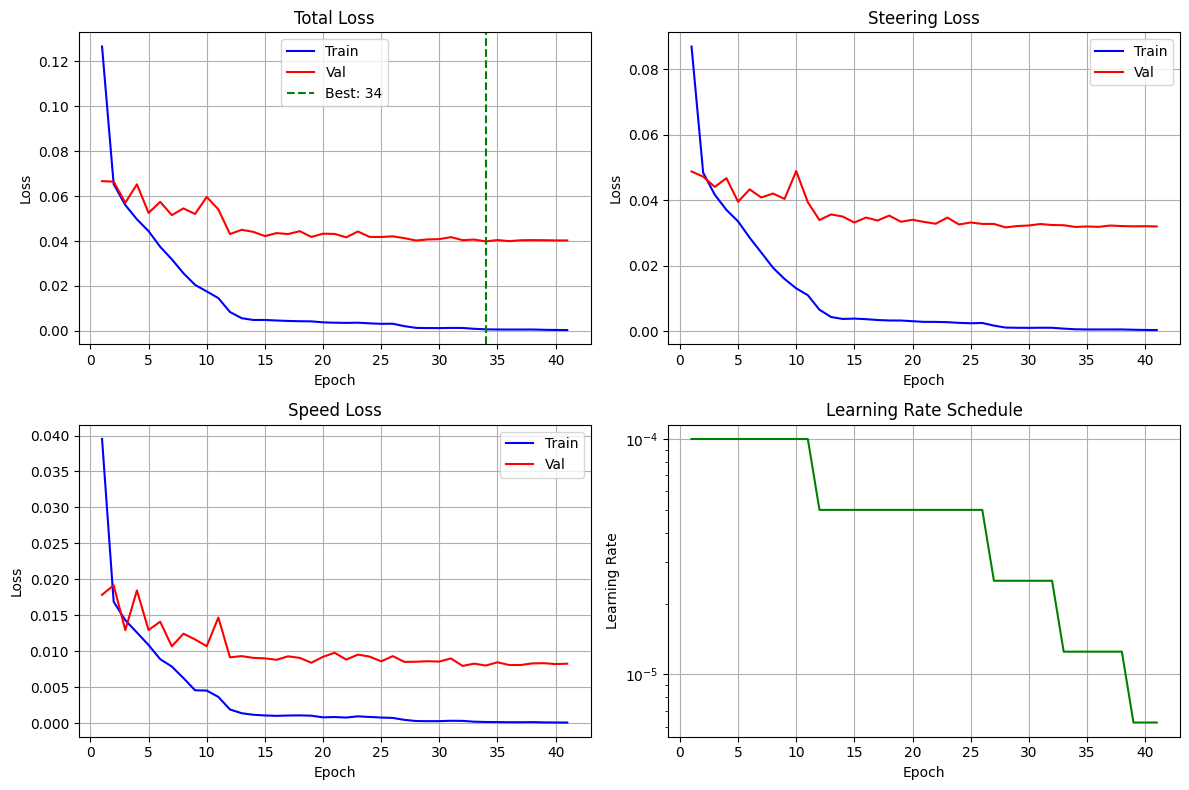

In [10]:
# Visualize training
plot_history(history)

EVALUATION
Steering - MSE: 0.031830, MAE: 0.110601
Speed    - MSE: 0.008011, MAE: 0.029330


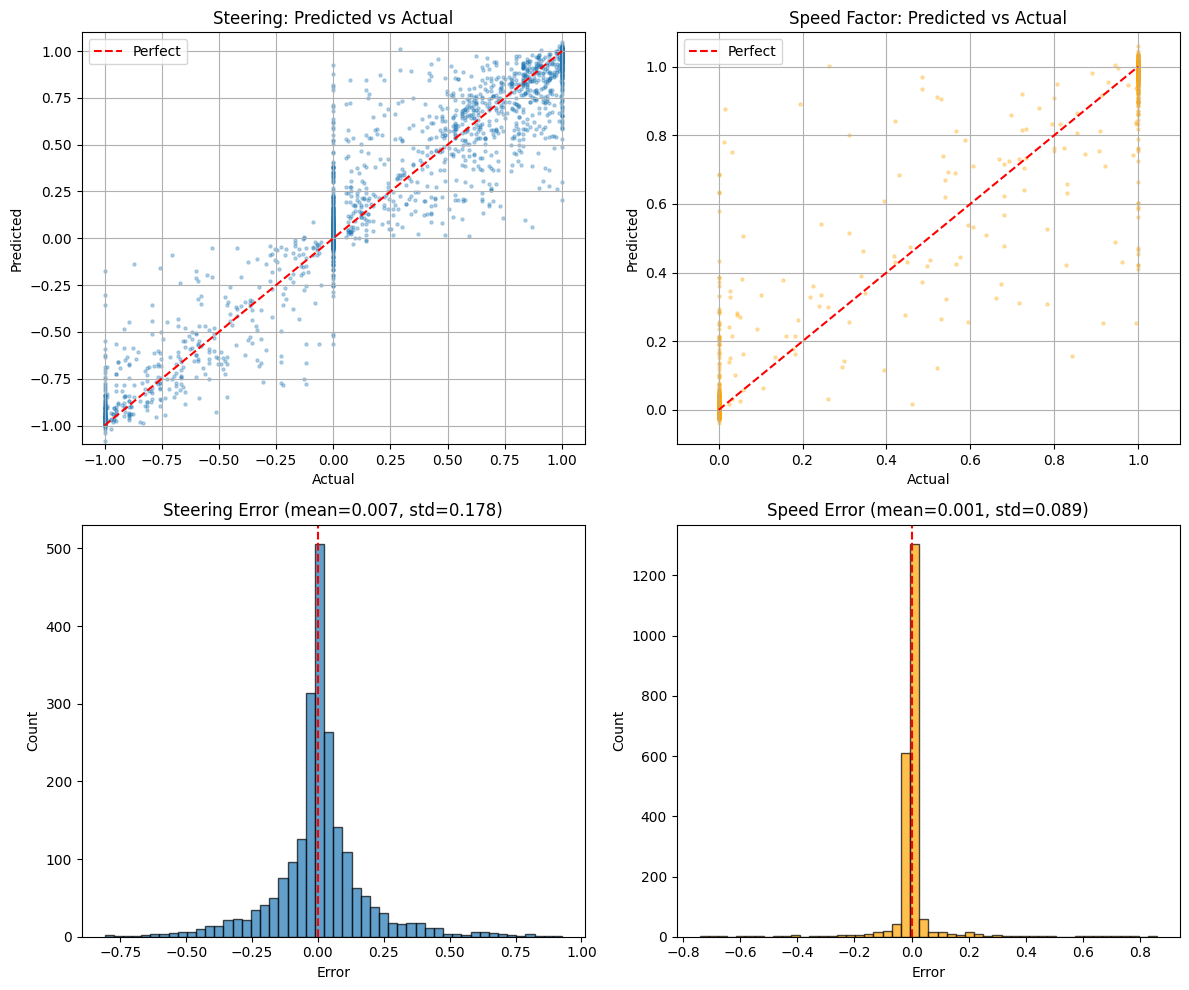

In [11]:
# Evaluate
results = evaluate_model(model, val_loader)
plot_predictions(results)

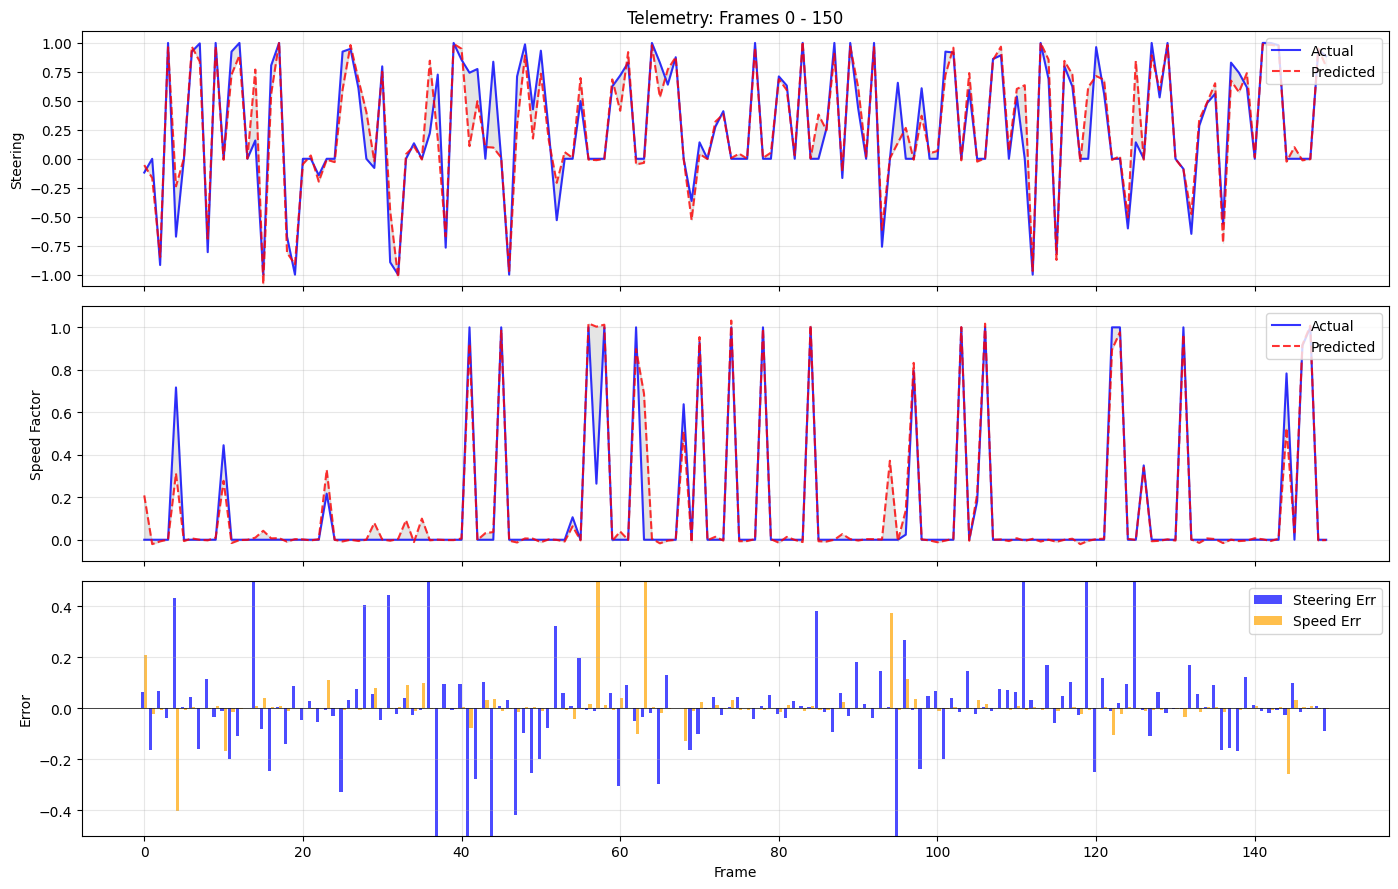

Segment MAE - Steering: 0.1184, Speed: 0.0325


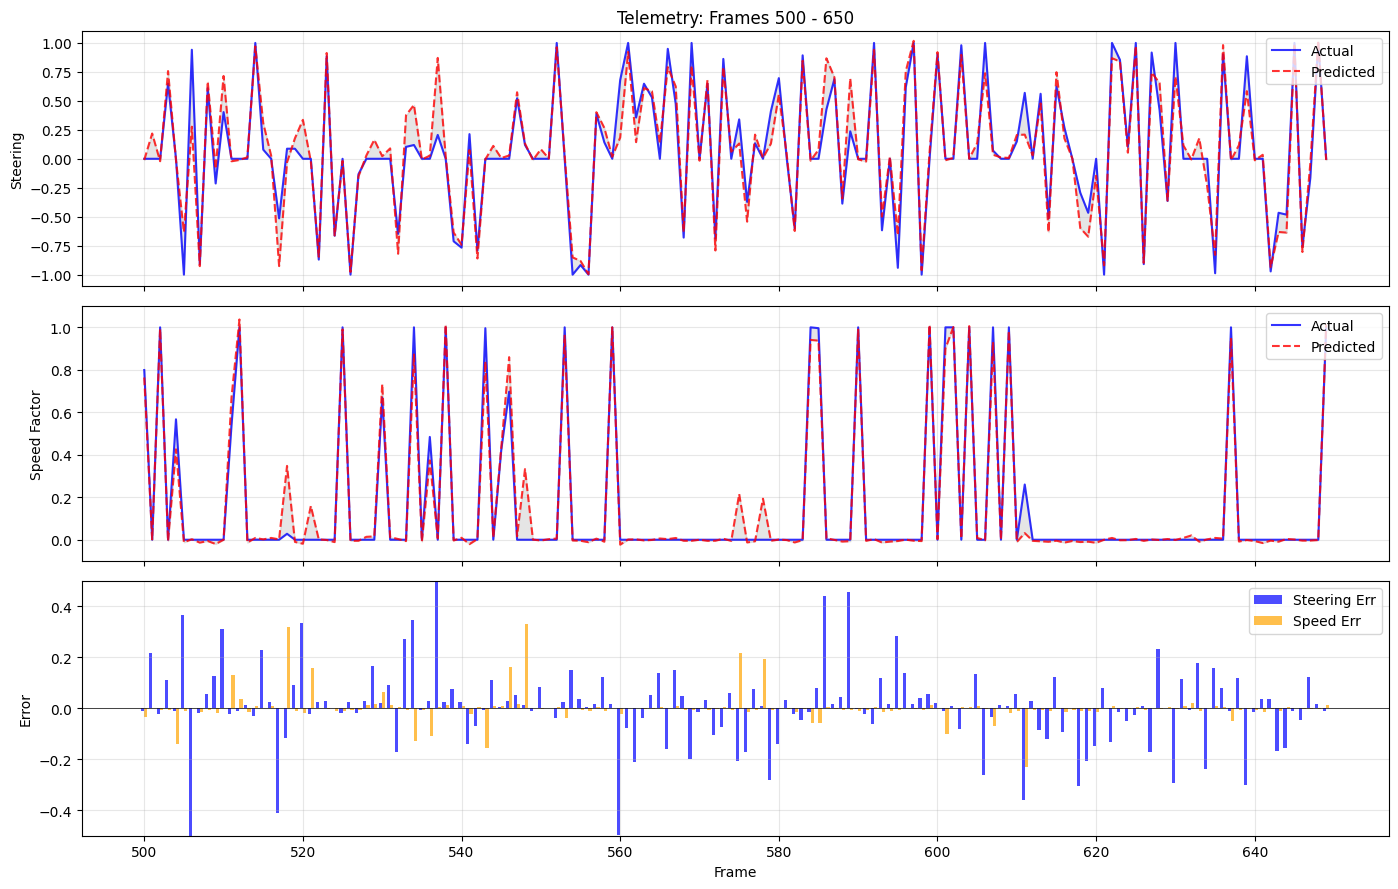

Segment MAE - Steering: 0.1050, Speed: 0.0244


In [12]:
# Telemetry
plot_telemetry(results, start=0, length=150)
plot_telemetry(results, start=500, length=150)

Saliency for STEERING:


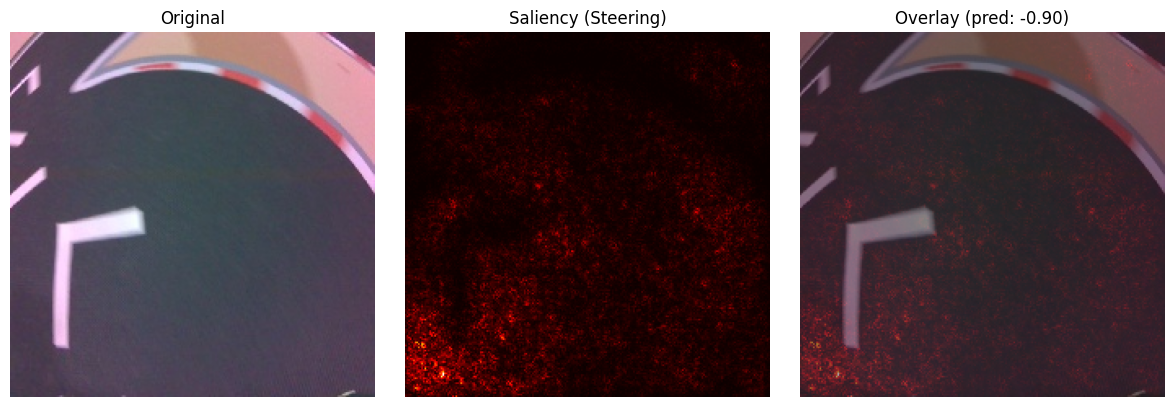


Saliency for SPEED:


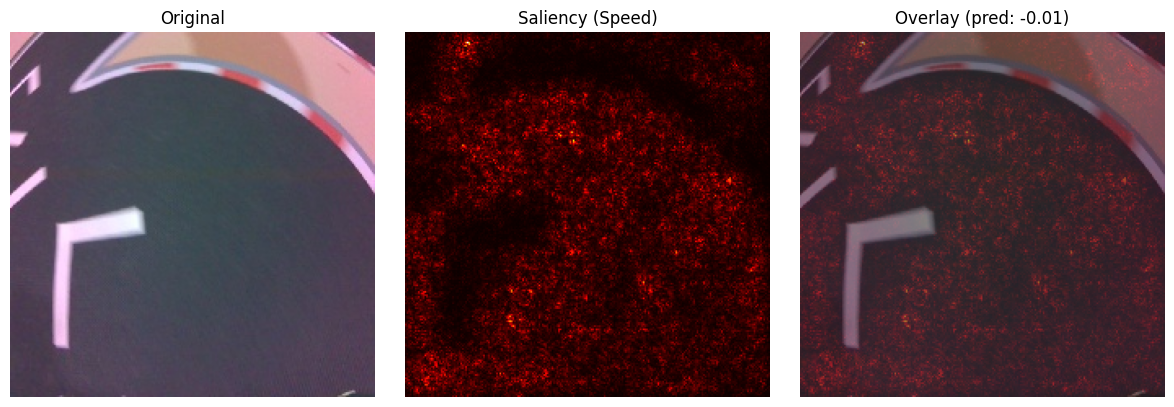

In [13]:
# Saliency maps
sample_images = glob.glob(os.path.join(DATASET_DIR, "*.jpg"))
sample_img = random.choice(sample_images)

print("Saliency for STEERING:")
plot_saliency(model, sample_img, output_idx=0)

print("\nSaliency for SPEED:")
plot_saliency(model, sample_img, output_idx=1)